In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
path = './data/AmesHousing.txt'

data = pd.read_table(path, index_col=0)

In [3]:
data.head(5)

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
data.shape[0]

2930

According to kaggle description, this dataset doesn't contain any errors in data entries or physically impossible values, but still it's better to check at least date/time features.

In [5]:
time_feats = ['Mo Sold', 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add']
print(data[time_feats].isna().sum())

Mo Sold             0
Yr Sold             0
Garage Yr Blt     159
Year Built          0
Year Remod/Add      0
dtype: int64


In [6]:
data[time_feats].describe()

,Mo Sold,Yr Sold,Garage Yr Blt,Year Built,Year Remod/Add
count,2930.000000,2930.000000,2771.000000,2930.000000,2930.000000
mean,6.216041,2007.790444,1978.132443,1971.356314,1984.266553
std,2.714492,1.316613,25.528411,30.245361,20.860286
min,1.000000,2006.000000,1895.000000,1872.000000,1950.000000
25%,4.000000,2007.000000,1960.000000,1954.000000,1965.000000
50%,6.000000,2008.000000,1979.000000,1973.000000,1993.000000
75%,8.000000,2009.000000,2002.000000,2001.000000,2004.000000
max,12.000000,2010.000000,2207.000000,2010.000000,2010.000000


In [7]:
data[data['Garage Yr Blt'].notna()]['Garage Yr Blt'].sort_values()

Order
1555    1895.0
308     1896.0
2600    1900.0
170     1900.0
2636    1900.0
         ...  
105     2010.0
39      2010.0
317     2010.0
46      2010.0
2261    2207.0
Name: Garage Yr Blt, Length: 2771, dtype: float64

We can see that there's one error in data entry for 'Garage Yr Built'. It should be dropped.

In [8]:
data.drop(2261, inplace=True)

Feature 'PID' is useless

In [9]:
# drop column PID, it's useless
data.drop('PID', axis=1, inplace=True)

'MS SubClass' is in fact categorical feature, so let's change corresponding column type to 'object'

In [10]:
data['MS SubClass'] = data['MS SubClass'].astype('object')

Let's look for outliers in histograms

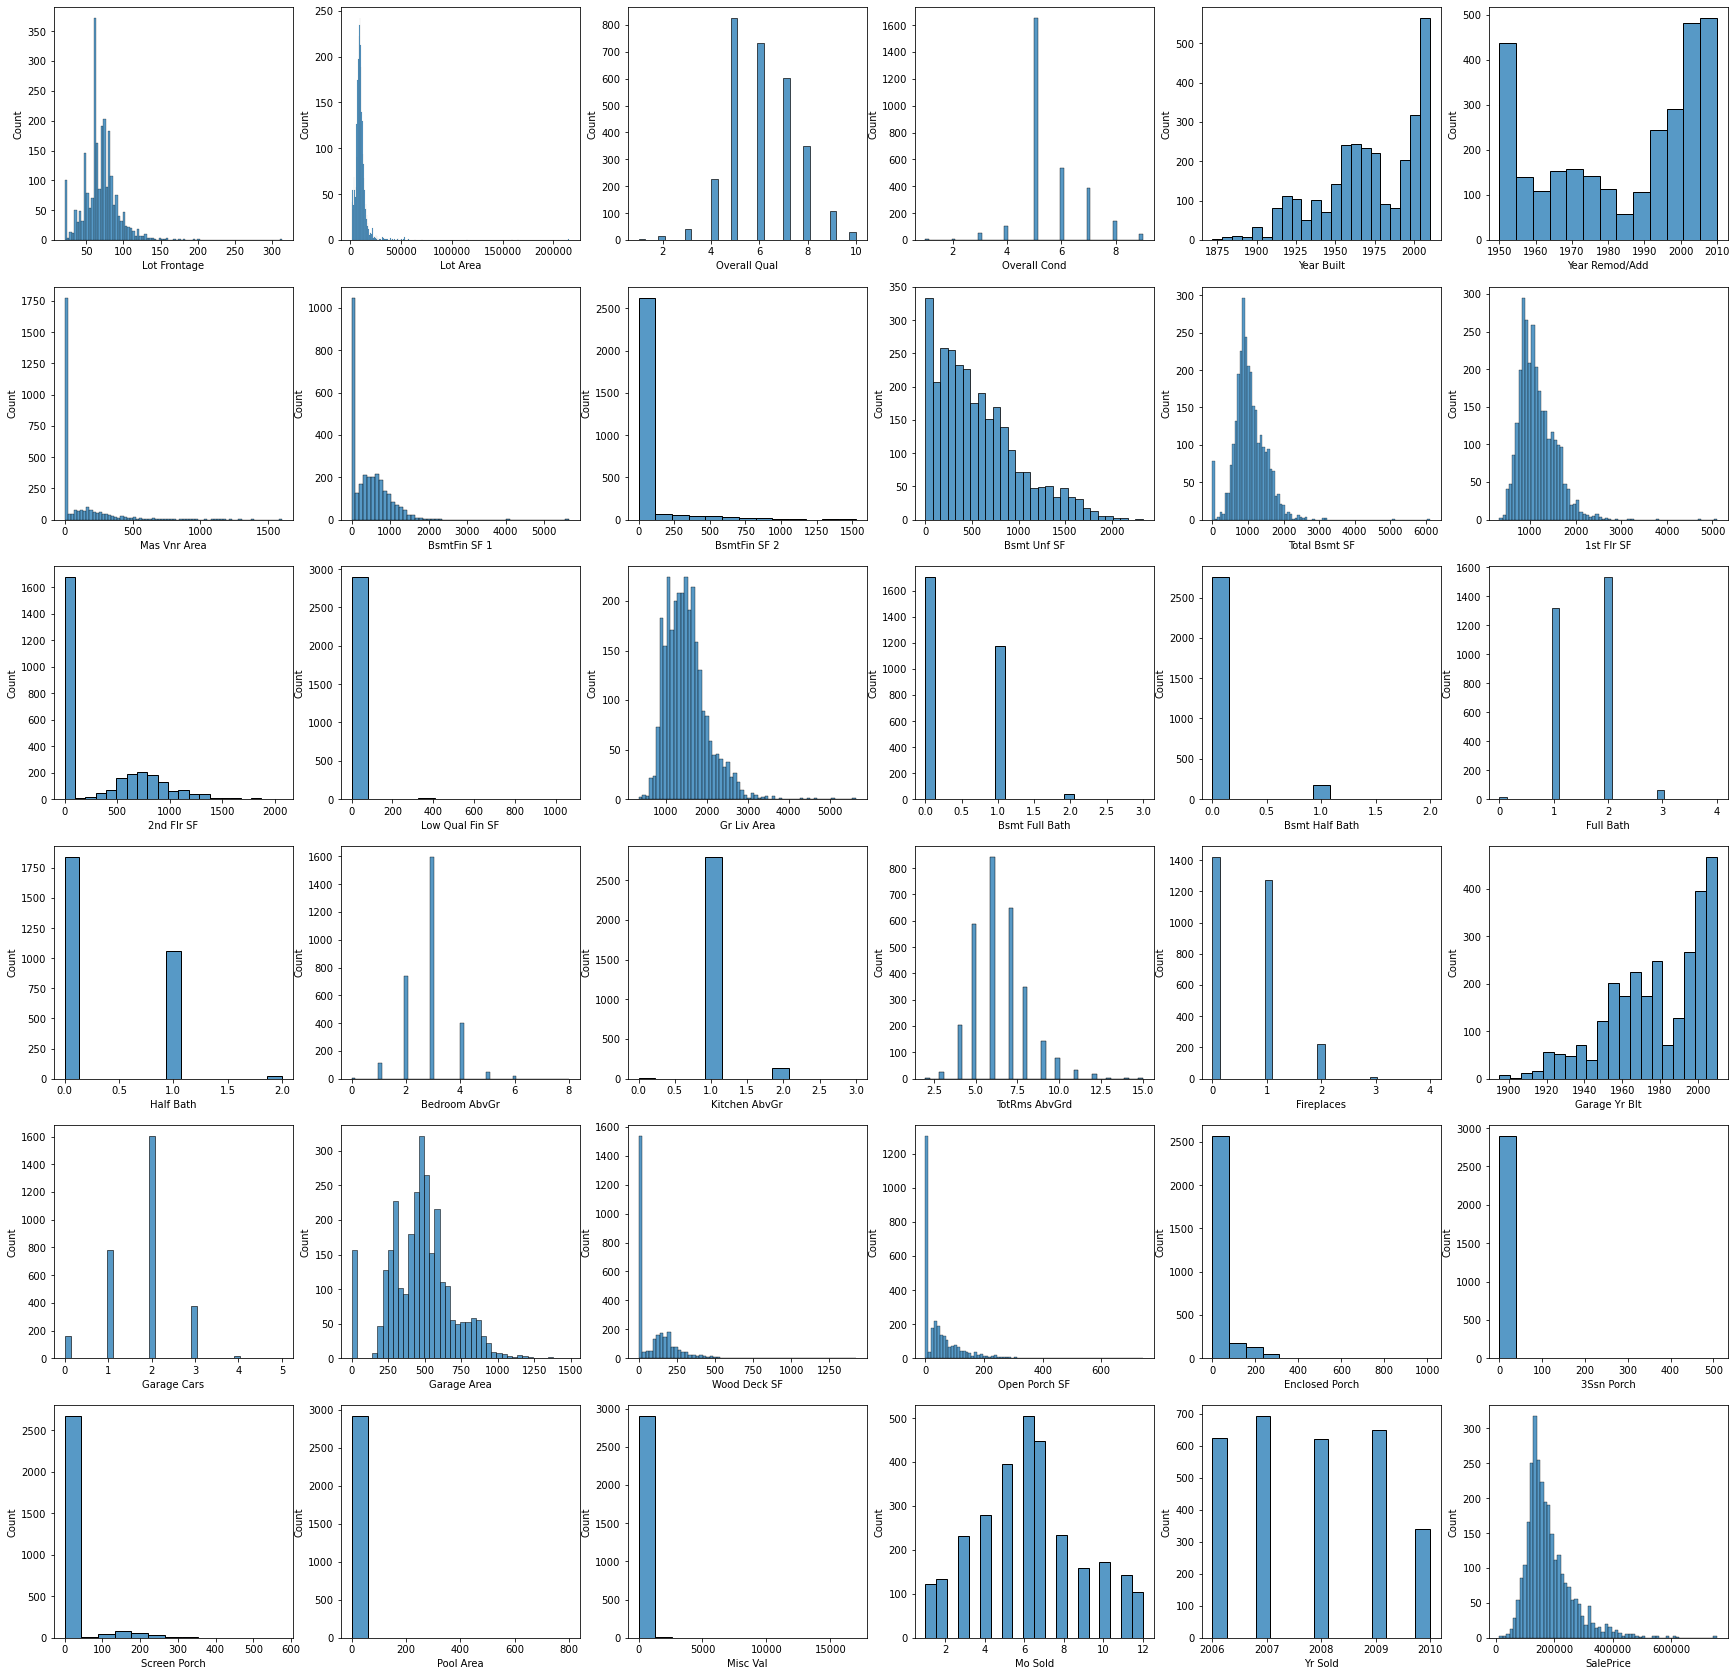

In [11]:
num_feats = data.select_dtypes(exclude='object')
x = int(np.ceil(np.sqrt(num_feats.shape[1])))
fig, axs = plt.subplots(x, x, figsize=(30,30))

for idx, col in enumerate(num_feats.columns):
    # sns.ecdfplot(x=col, data=data, ax=axs[idx//x, idx%x]);
    sns.histplot(x=col, data=data, ax=axs[idx//x, idx%x], stat="count");

We can see that the tail of distribution of target varible is very heavy so it should be good to cut it using rule of 3 sigma. Also it seems reasonable to filter 'Garage Area', 'Lot Area', 'Total Bsmt SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Misc Val', all kinds of porches, 'Pool Area', 'Misc Vals'.

In [12]:
cols_to_filter = ['SalePrice', 'Garage Area', 'Total Bsmt SF', 
                  'BsmtFin SF 1', 'BsmtFin SF 2', 'Misc Val',
                  'Pool Area', 'Screen Porch', '3Ssn Porch',
                  'Enclosed Porch', 'Open Porch SF', 'Wood Deck SF',
                  'Lot Area', 'Lot Frontage']
mask = data['SalePrice'] == data['SalePrice']
for col in cols_to_filter:
    threshold = data[col].quantile(0.997)
    mask = mask & ~(data[col] > threshold)
data = data.loc[mask, :]

Let's check if there are any redundant features

In [13]:
data.count().sort_values()

Pool QC            2
Misc Feature      89
Alley            192
Fence            545
Fireplace Qu    1429
                ... 
Central Air     2830
1st Flr SF      2830
2nd Flr SF      2830
Gr Liv Area     2830
SalePrice       2830
Length: 80, dtype: int64

We have 3 features which have useful values in less than 10% of all entries. Probably it's best to drop them.

In [14]:
data.drop(['Pool QC', 'Misc Feature', 'Alley'], axis=1, inplace=True)

Also let's check how many values differ from zero.

In [15]:
(num_feats!=0).sum()

Lot Frontage       2929
Lot Area           2929
Overall Qual       2929
Overall Cond       2929
Year Built         2929
Year Remod/Add     2929
Mas Vnr Area       1181
BsmtFin SF 1       1999
BsmtFin SF 2        352
Bsmt Unf SF        2685
Total Bsmt SF      2850
1st Flr SF         2929
2nd Flr SF         1252
Low Qual Fin SF      40
Gr Liv Area        2929
Bsmt Full Bath     1223
Bsmt Half Bath      177
Full Bath          2917
Half Bath          1087
Bedroom AbvGr      2921
Kitchen AbvGr      2926
TotRms AbvGrd      2929
Fireplaces         1507
Garage Yr Blt      2929
Garage Cars        2772
Garage Area        2772
Wood Deck SF       1403
Open Porch SF      1630
Enclosed Porch      459
3Ssn Porch           37
Screen Porch        256
Pool Area            13
Misc Val            103
Mo Sold            2929
Yr Sold            2929
SalePrice          2929
dtype: int64

We observe 3 features which values differ from zero in less than 2%. It's certainly good to drop them. Although, we'll leave for the time being column 'Low Qual Fin SF' since maybe it's part of the more complex feature.

In [16]:
data.drop(['3Ssn Porch', 'Pool Area'], axis=1, inplace=True)

Let's lower precision for speed purposes

In [17]:
float_cols = data.select_dtypes(include='float64').columns
int_cols = data.select_dtypes(include='int64').columns

data.loc[:, float_cols] = data.loc[:, float_cols].astype('float32')
data.loc[:, int_cols] = data.loc[:, int_cols].astype('int32')

Let's split our columns based on their type.

In [18]:
col_by_type = defaultdict(list)
for index, value in data.dtypes.items():
    col_by_type[str(value)].append(index)

col_by_type.keys()

dict_keys(['object', 'float32', 'int32'])

For all columns with 'object' dtype we'll fill their NaNs with 'missing' value and then convert to string

In [19]:
cat_feats = col_by_type['object']

data.loc[:, cat_feats] = data.loc[:, cat_feats].fillna('missing').astype('string')
data.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Open Porch SF,Enclosed Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,62,0,0,missing,0,5,2010,WD,Normal,215000
2,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,MnPrv,0,6,2010,WD,Normal,105000
4,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,missing,0,4,2010,WD,Normal,244000
5,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,MnPrv,0,3,2010,WD,Normal,189900
6,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,missing,0,6,2010,WD,Normal,195500


For columns with 'float32' and 'int32' we'll first inspect unique values, taking into account their total count

In [20]:
float_cols = col_by_type['float32']
val_counts_float_cols = data[float_cols].nunique()
val_counts_float_cols

Lot Frontage       122
Mas Vnr Area       429
BsmtFin SF 1       965
BsmtFin SF 2       256
Bsmt Unf SF       1113
Total Bsmt SF     1022
Bsmt Full Bath       4
Bsmt Half Bath       3
Garage Yr Blt      102
Garage Cars          6
Garage Area        579
dtype: int64

In [21]:
few_unique_vals = val_counts_float_cols[val_counts_float_cols<=10].index
many_unique_vals = val_counts_float_cols[val_counts_float_cols>10].index

for col in few_unique_vals:
    print(col + ': ', data[col].unique())

Bsmt Full Bath:  [ 1.  0.  2.  3. nan]
Bsmt Half Bath:  [ 0.  1. nan  2.]
Garage Cars:  [ 2.  1.  3.  0.  4.  5. nan]


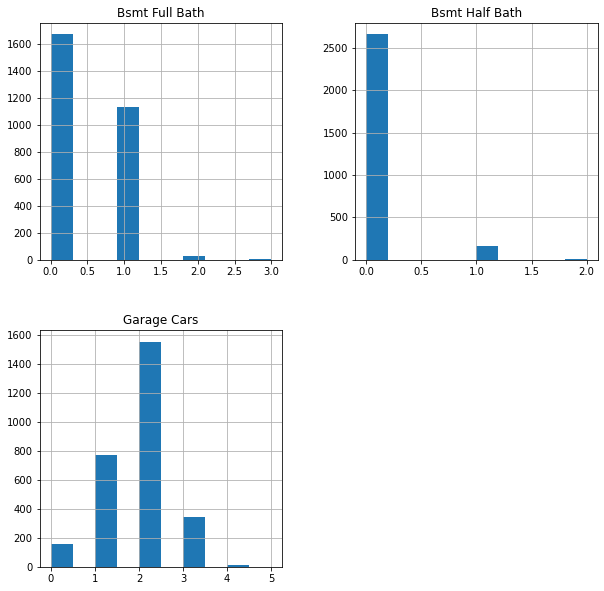

In [22]:
data[few_unique_vals].hist(figsize=(10, 10));

As we can see, these features are in fact integer features with few unique values, so probably it would be best to fill their values with median to preserve data structure

In [23]:
data[few_unique_vals] = data[few_unique_vals].fillna(data.median()).astype('int32')

In [24]:
for col in few_unique_vals:
    col_by_type['float32'].remove(col)
    col_by_type['int32'].append(col)

For other 'float32' features we'll use mean values to fill NaNs

In [25]:
data[many_unique_vals] = data[many_unique_vals].fillna(data.mean())

For 'int32' we'll also fill NaNs with medians for features with low count of unique values\
Others we'll fill with means

In [26]:
int_cols = col_by_type['int32'][:-3]
val_counts_int_cols = data[int_cols].nunique()
val_counts_int_cols

Lot Area           1889
Overall Qual         10
Overall Cond          9
Year Built          117
Year Remod/Add       61
1st Flr SF         1046
2nd Flr SF          610
Low Qual Fin SF      33
Gr Liv Area        1246
Full Bath             5
Half Bath             3
Bedroom AbvGr         8
Kitchen AbvGr         4
TotRms AbvGrd        13
Fireplaces            4
Wood Deck SF        357
Open Porch SF       239
Enclosed Porch      171
Screen Porch        110
Misc Val             28
Mo Sold              12
Yr Sold               5
SalePrice           998
dtype: int64

In [27]:
few_unique_vals = val_counts_int_cols[val_counts_int_cols<=10].index
many_unique_vals = val_counts_int_cols[val_counts_int_cols>10].index

data[few_unique_vals] = data[few_unique_vals].fillna(data.median())
data[many_unique_vals] = data[many_unique_vals].fillna(data.mean())

In [30]:
data.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Open Porch SF,Enclosed Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,62,0,0,missing,0,5,2010,WD,Normal,215000
2,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,MnPrv,0,6,2010,WD,Normal,105000
4,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,missing,0,4,2010,WD,Normal,244000
5,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,MnPrv,0,3,2010,WD,Normal,189900
6,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,missing,0,6,2010,WD,Normal,195500
